# Unsupervised Feature Learning for Object Segmentation (and Star-galaxy Classification)

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits

import theano
import lasagne
import theano.tensor as T

## Introduction

In our previous work ([Kim & Brunner 2016](https://arxiv.org/abs/1608.04369)), we showed that convolutional neural networks (ConvNets) are able to produce accurate star-galaxy classifications by learning directly from the pixel values of photometric images.

The major advantage of deep learning is that useful features are learned automatically from images. Since we expect unsupervised learning to become more important in future photometric surveys, we will explore the use of unsupervised learning that leverages deep neural netowkrs to extract useful features. The extracted features can then be combined in a separate learning stage (e.g., clustering methods such as k-means) to produce pixel-level classification (i.e., semantic segmentation).

How do we train a classifier without any labels? We assign "surrogate" classes, and train the network to discriminate between a set of surrogate classes. This idea was inspired by [Dosovitskiy et al. (2014)](https://arxiv.org/abs/1406.6909). Another possibility is to use generative adversial networks, but here I will focus on using surrogate classes.

We can sample random image patches from a large image like the one on the left in the below figure, and then apply various transformations that exploit label-preserving symmetry, e.g., rotational symmetry, mirror symmetry, color perturbation. Every image that originated from a "seed" patch belongs to the same surrogate class.

![](images/examplar.png)

This model will actually have no trouble learning the feature representations, and as a bonus, the learned features won't be class-specific in contrast to supervised methods. However, the final output layer can't be used for any useful tasks because it will produce classifications for random labels that we assigned to the seed patches. Thus, a separate learning stage that leverages the learned features is necessary.

![](images/clustering.png)

## Training Set

In this demonstration, I will use a _single_ SDSS field image. Each field image is 2048 by 1489 pixels. 

Furthermore, since the flux values are expressed in units of _nanomaggies_, we will convert the values to _luptitudes_. See [here](https://www.sdss3.org/dr8/algorithms/magnitudes.php) for more information.

(1489, 2048)


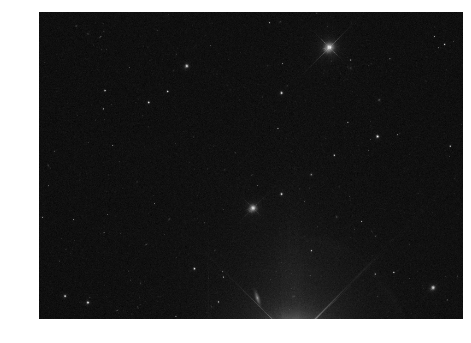

In [2]:
# we will import a custom module located in ..
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pixelsg.patch import nanomaggie_to_luptitude

field_image = fits.getdata("../frame-r-000109-2-0037.fits")
print(field_image.shape)
field_image = nanomaggie_to_luptitude(field_image, 'r')
plt.imshow(field_image)
plt.axis("off");

For demonstration purposes, I will only use the images in $g$, $r$, and $i$ bands. Ideally, we also want to extract information from the $u$ and $z$ bands.

Now, we want to form the initla training set by randomly sampling $N$ patches of size $64 \times 64$ pixels at varying positions. Since we are primarily interested in patches containing objects or parts of objects, we sample a patch with probability proportional to mean squared gradient magnitude within the patch.

In [3]:
from pixelsg.train import load_training_set

# image in g and i bands were aligned using montage.
# (hence the "registered.fits" file extension.)
# see "cutout" tool:
# https://github.com/edwardjkim/image-cutout
frames =[
    "../frame-g-000109-2-0037.registered.fits",
    "../frame-r-000109-2-0037.fits",
    "../frame-i-000109-2-0037.registered.fits"
]

X, y = load_training_set(filenames=frames, bands="gri", num_classes=100, size=64)

print(X.shape)

(100, 3, 64, 64)


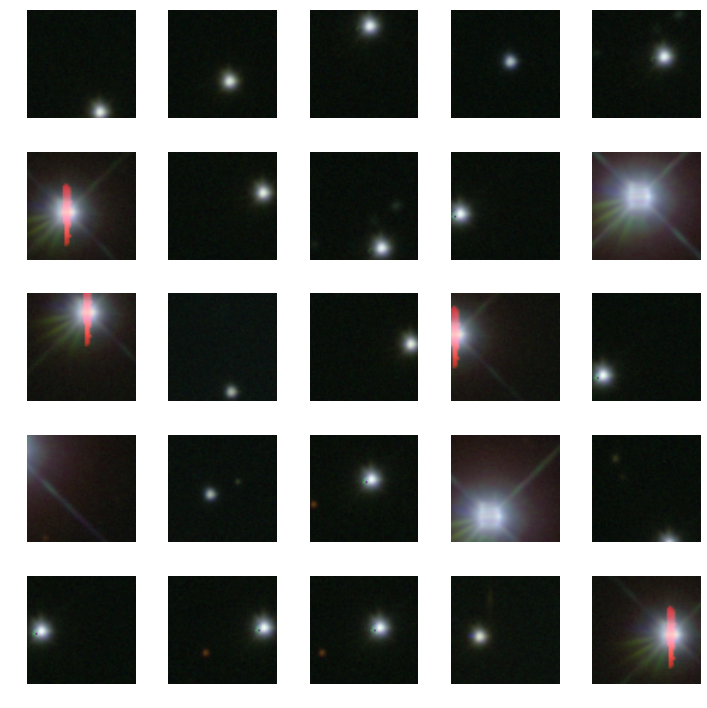

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        ax[i, j].imshow(1 - X[idx, ::-1].transpose(1, 2, 0))
        ax[i, j].set_axis_off()
        
plt.tight_layout()

## Creating Surrogate Training Data

Inspired by [Dosovitskiy et al. (2014)](https://arxiv.org/abs/1406.6909).

Each seed image is transformed as follows (for now):

- Rotation: Rotating an image does not change whether the object
is a star or a galaxy. We exploit this rotational symmetry and
randomly rotate each image by a multiple of $90^{\circ}$.

- Reflection: We flip each image horizontally with a probability
of 0.5 to exploit mirror symmetry.

- Gaussian noise: We introduce random Gaussian noise to each
pixel values by using a similar method to Krizhevsky et al. (2012).

All transformations that originated from the same seed image are given an identical surrogate class label.

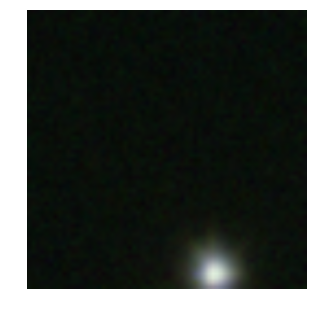

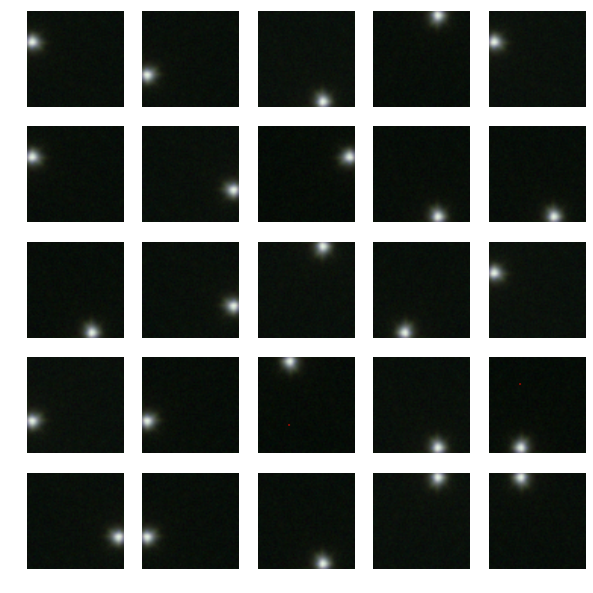

In [5]:
from pixelsg.patch import augment

# original image
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax1.imshow(1 - X[0, ::-1].transpose(1, 2, 0))
ax1.set_axis_off()

# transformed images
transformed = np.array([X[0], ] * 25)
transformed = augment(transformed)

fig2, ax2 = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        ax2[i, j].imshow(1 - transformed[idx, ::-1].transpose(1, 2, 0))
        ax2[i, j].set_axis_off()

## Pre-trained ConvNet for classiyfing image patch -> surrogate class

We load a pre-trained model here. To see the architecture, uncomment the line with `build_cnn??`. The model was trained on a single SDSS field with $N$ (the number of surrogate classes) on NVIDIA K20 GPU.

In [6]:
from pixelsg.models import build_cnn

#build_cnn??

In [7]:
from pixelsg.params import load_params

network = build_cnn(input_var=X, num_outputs=1000, size=64, num_channels=3)
load_params(network, '../model.params')
layers = lasagne.layers.get_all_layers(network)

for idx, layer in enumerate(layers):
    print(idx, layer)

0 <lasagne.layers.input.InputLayer object at 0x7fcc2aa748d0>
1 <lasagne.layers.conv.Conv2DLayer object at 0x7fcc2aa1f5c0>
2 <lasagne.layers.normalization.BatchNormLayer object at 0x7fcc2a962ba8>
3 <lasagne.layers.special.NonlinearityLayer object at 0x7fcc2a8fb1d0>
4 <lasagne.layers.conv.Conv2DLayer object at 0x7fcc2a8fbf28>
5 <lasagne.layers.normalization.BatchNormLayer object at 0x7fcc2a95ee80>
6 <lasagne.layers.special.NonlinearityLayer object at 0x7fcc29fdddd8>
7 <lasagne.layers.pool.MaxPool2DLayer object at 0x7fcc2a26d978>
8 <lasagne.layers.conv.Conv2DLayer object at 0x7fcc2a83c198>
9 <lasagne.layers.normalization.BatchNormLayer object at 0x7fcc2a7c7080>
10 <lasagne.layers.special.NonlinearityLayer object at 0x7fcc2a042710>
11 <lasagne.layers.conv.Conv2DLayer object at 0x7fcc2a0353c8>
12 <lasagne.layers.normalization.BatchNormLayer object at 0x7fcc2a031710>
13 <lasagne.layers.special.NonlinearityLayer object at 0x7fcc2a0213c8>
14 <lasagne.layers.pool.MaxPool2DLayer object at 0x7fcc

## Hypercolumns: Extracting Features for Pixel-level Segmentation 

The simplest way of using the learned features is cutting off the final output layer. However, we want to do **pixel-level** semantic segmentation. We will use _hypercolumns_ to combine the features. See the original paper: [Hypercolumns for Object Segmentation and Fine-grained Localization](https://arxiv.org/abs/1411.5752) by Hariharan et al.

![](images/hypercolumn.png)
<div style="text-align:center">Hypercolumn representation (Image source: [Hariharan et al. (2014)](https://arxiv.org/abs/1411.5752))</div>

In [8]:
# build_cnn??

In [9]:
#indices = [3, 6, 10, 13, 17, 20, 23, 27, 30, 33]
indices = [6, 13, 23, 33]

def get_some_layers(network, indices):

    layers = lasagne.layers.get_all_layers(network)
    layers = [
        layer for idx, layer in enumerate(layers)
        if idx in indices
    ]
    
    return layers

layers = get_some_layers(network, indices)
print(layers)

[<lasagne.layers.special.NonlinearityLayer object at 0x7fcc29fdddd8>, <lasagne.layers.special.NonlinearityLayer object at 0x7fcc2a0213c8>, <lasagne.layers.special.NonlinearityLayer object at 0x7fcc2a010da0>, <lasagne.layers.special.NonlinearityLayer object at 0x7fcc2a07b908>]


In [10]:
from pixelsg.train import extract_hypercolumns

In [11]:
# extract_hypercolumn??

In [12]:
from sklearn.cluster import MiniBatchKMeans


def get_num_feature_maps(layers):
    
    layer_shapes = lasagne.layers.get_output_shape(layers)
    n_feature_maps = sum(shape[1] for shape in layer_shapes)
    
    return n_feature_maps

def aggregate_hypercolumns(network, indices, inputs, memmap_file="hypercolumns.npy"):
    
    layers = get_some_layers(network, indices)
    n_feature_maps = get_num_feature_maps(layers)
    
    n_samples, _, size, _ = inputs.shape
    
    # we have n_feature_maps > 1,000 (if we use all conv layers)
    # for EACH pixel of every image, so we will use memmap
    # to avoid potential memory problems
    hc = np.memmap(
        memmap_file,
        shape=(size ** 2 * n_samples, n_feature_maps),
        dtype="float32", mode="w+"
    )

    for i in range(n_samples):
        current = extract_hypercolumns(
            network, indices, inputs[i: i + 1], size
        )
        # each hypercolumn has shape (# feature maps, size, size)
        current = current.transpose(1, 2, 0).reshape((size ** 2, -1))
        hc[size ** 2 * i: size ** 2 * (i + 1)] = current
        
    return hc

hypercolumns = aggregate_hypercolumns(network, indices, X[:100])

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Clustering

Now that we have the hypercolumns for each pixel, we will use k-means clustering to assign labels to every single pixel in the data set. I will use $k=2$ for now (i.e., objects vs. background).

In [13]:
kmeans = MiniBatchKMeans(n_clusters=2, compute_labels=False)
kmeans.fit(hypercolumns)

MiniBatchKMeans(batch_size=100, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [14]:
y_pred = np.zeros((64 **2 * 10, ))

batch_size = 128

for start_idx in range(0, 64 ** 2 * 10 - batch_size + 1, batch_size):
    excerpt = hypercolumns[start_idx: start_idx + batch_size]
    y_batch = kmeans.predict(excerpt)
    y_pred[start_idx: start_idx + batch_size] = y_batch

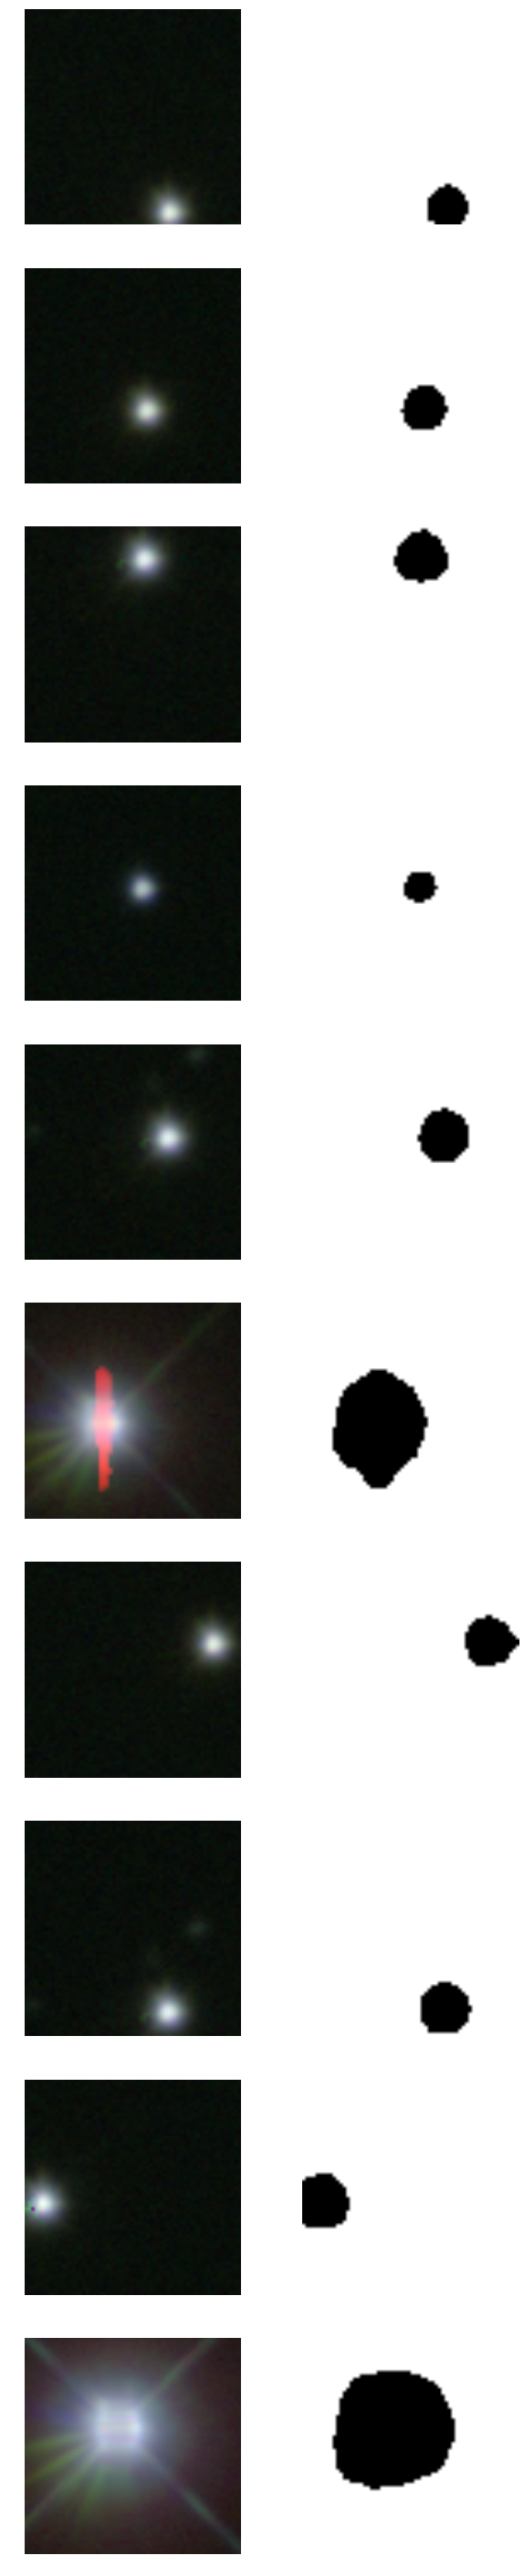

In [15]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10, 50))
cmap = 'gray'

for i in range(10):
    
    patch = X[i, ::-1].transpose((1, 2, 0))
    ax[i, 0].imshow(1 - patch)
    ax[i, 0].axis('off')
    
    label_map = y_pred[64 ** 2 * i: 64 ** 2 * (i + 1)].reshape(64, 64)
    ax[i, 1].imshow(label_map, cmap=cmap)
    ax[i, 1].axis('off')

## Object Segmentation

We can also apply the same procedure to the SDSS field. For an image larger than $64\times64$, we can simply a $64\times64$ windows over the entire image and aggregate the results at the end.

In [16]:
field_images = [
    nanomaggie_to_luptitude(fits.getdata("../frame-g-000109-2-0037.registered.fits"), 'g'),
    nanomaggie_to_luptitude(fits.getdata("../frame-r-000109-2-0037.fits"), 'r'),
    nanomaggie_to_luptitude(fits.getdata("../frame-i-000109-2-0037.registered.fits"), 'r')
]
field_images = np.stack(field_images)

def scale(x):
    return (x - x.min()) / (x.max() - x.min())

# crop a little bit because alignment produces some NaN values at the edges
field_images = field_images[:, 64: -64, 64: -64]

#n_rows = int(field_images.shape[1] / 64)
#n_cols = int(field_images.shape[2] / 64)

n_rows = 4
n_cols = 4

field_images = field_images[:, :64 * n_rows, :64 * n_cols]

assert np.sum(np.isnan(field_images)) == 0

for i in range(3):
    field_images[i] = scale(field_images[i])

In [17]:
segmented = np.zeros((n_rows * 64, n_cols * 64))

for i in range(n_rows):
    for j in range(n_cols):
        tile = field_images[:, i * 64: (i + 1) * 64, j * 64: (j + 1) * 64]
        tile = tile.reshape((1, 3, 64, 64))
        hc = extract_hypercolumns(network, indices, tile)
        hc = hc.transpose(1, 2, 0).reshape((64 ** 2, -1))
        pred = kmeans.predict(hc)
        pred = pred.reshape((64, 64))
        segmented[i * 64: (i + 1) * 64, j * 64: (j + 1) * 64] = pred

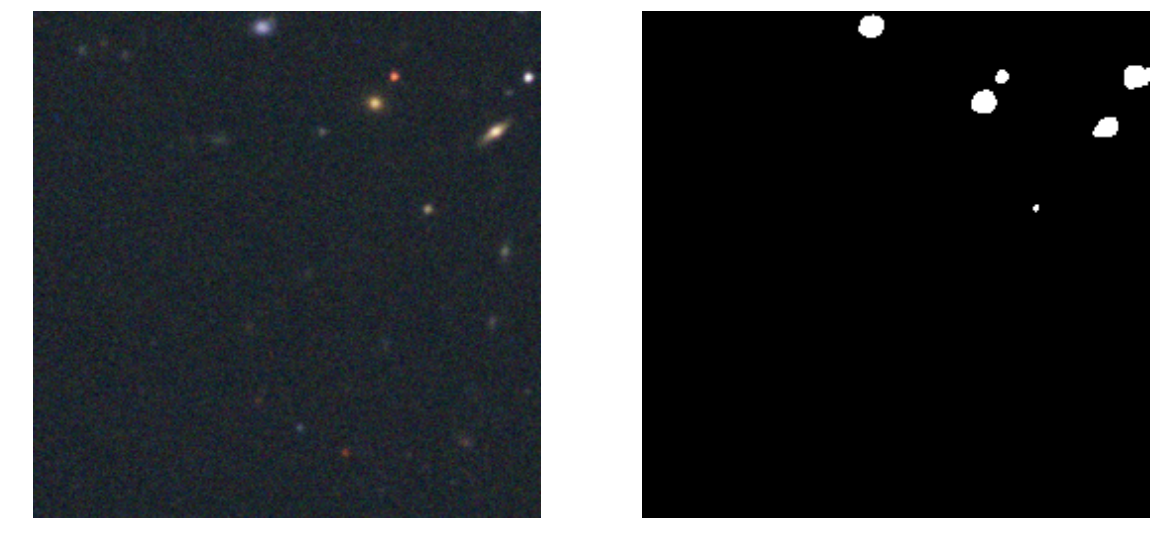

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

ax[0].imshow(1 - field_images[::-1].transpose((1, 2, 0)))
ax[0].axis("off")

ax[1].imshow(segmented)
ax[1].axis('off');

It looks like the model is having difficulty classifying faint objects. This is likely due to the number of surrogate classes (patches) I used for training the CNN. Since the patches are drawn from a distribution proportional to the (mean squared) image gradient, the training set probably had too few faint objects.

## TODO

- More training data.
- More surrogate classes to include more faint objects.
- Use all 5 ugriz bands.
- More cluster labels (stars, galaxies, quasars, not just object vs. background).
- Supervised learning in the second learning stage (semi-supervised).